In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import time
import torch
from tqdm import tqdm
from sklearn import metrics
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import OrderedDict


In [4]:
class ChessData(torch.utils.data.Dataset):
    def __init__(self, path):
        self.df = pd.read_csv(path, index_col=0)
        self.column_names = self.df.columns[321:]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        inputs = row[:321].values.astype(np.float32)
        outputs = row[321:].values.astype(np.float32)

        return {'board': inputs, 'themes': outputs}


In [5]:
batch_size = 256

chess_data_set = ChessData('cleaned_data/cleaned_train_puzzles.csv')

train_dataloader = DataLoader(chess_data_set, batch_size=batch_size, num_workers=4, persistent_workers=True, shuffle=True)

In [6]:
chess_validation_set = ChessData('cleaned_data/cleaned_validation_puzzles.csv')

validation_dataloader = DataLoader(chess_validation_set, batch_size=batch_size, num_workers=4, persistent_workers=True)

In [7]:
net = nn.Sequential(
    nn.Linear(321, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 28),
)

In [8]:
net.load_state_dict(torch.load("model-final-state.pth"))

<All keys matched successfully>

In [9]:
net = net.cuda()

In [10]:
correct = 0
num_batches = 0
y_pred = []
y_true = []

net.eval()

for batch in tqdm(validation_dataloader):
    y_true.append(batch['themes'])

    X = batch['board'].cuda()
    with torch.no_grad():
        pred = net(X).sigmoid().cpu()

    y_pred.append(pred)


y_pred = torch.vstack(y_pred).numpy()
y_true = torch.vstack(y_true).numpy()


100%|██████████| 607/607 [00:14<00:00, 40.89it/s]


/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/bastosgabriel/miniconda3/envs/chessenv/lib/python3.7/site-

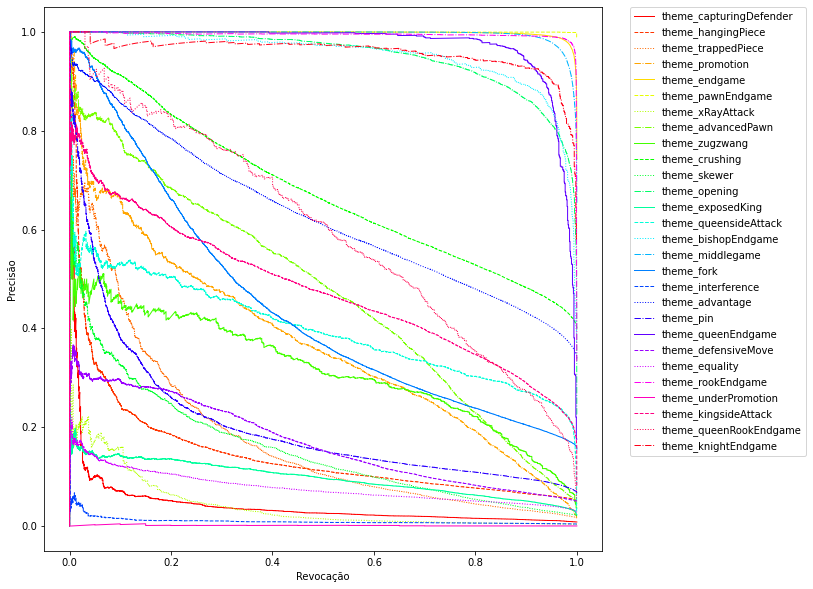

In [34]:
from cycler import cycler

total_precision_list = []
total_auroc_list = []
max_f1_list = []


hsv = plt.get_cmap('hsv')
colors = hsv(np.linspace(0, 1.0, y_pred.shape[1]))

default_cycler = (cycler(color=colors) +
                  cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--', ':', '-.',
                                    '-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--', ':', '-.',
                                    '-', '--', ':', '-.'])) # ['r', 'g', 'b', 'y']

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

plt.figure(figsize=(10, 10))

for i in range(y_pred.shape[1]):
    label_average_precision = metrics.average_precision_score(y_true[:,i], y_pred[:,i])
    label_auroc = metrics.roc_auc_score(y_true[:,i], y_pred[:,i])

    precision, recall, threshold = metrics.precision_recall_curve(y_true[:,i], y_pred[:,i])
    plt.plot(recall, precision, label = chess_validation_set.column_names[i]) #, prop_cycle=linestyle_cycler

    f1 = 2 * precision * recall / (precision + recall) #numpy list
    max_f1 = max(f1)

    max_f1_list.append(max_f1)
    total_precision_list.append(label_average_precision)
    total_auroc_list.append(label_auroc)


plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fancybox=True) # shadow = True

ax = plt.gca()
ax.set_ylabel(r'Precisão')
ax.set_xlabel(r'Revocação')
plt.show()

In [ ]:

total_precision_list

themes_list = ["theme_capturingDefender","theme_hangingPiece","theme_trappedPiece","theme_promotion","theme_endgame","theme_pawnEndgame","theme_xRayAttack", "theme_advancedPawn","theme_zugzwang","theme_crushing","theme_skewer","theme_opening","theme_exposedKing","theme_queensideAttack","theme_bishopEndgame","theme_middlegame","theme_fork","theme_interference","theme_advantage","theme_pin","theme_queenEndgame","theme_defensiveMove","theme_equality","theme_rookEndgame","theme_underPromotion","theme_kingsideAttack","theme_queenRookEndgame","theme_knightEndgame"]

precision_dict = OrderedDict({t:total_precision_list[i] for i, t in enumerate(themes_list)})
sorted_precisions = sorted(precision_dict.items(), key=lambda x: x[1], reverse=True)

sorted_precisions

In [13]:
auroc_dict = OrderedDict({t:total_auroc_list[i] for i, t in enumerate(themes_list)})
sorted_aurocs = sorted(auroc_dict.items(), key=lambda x: x[1], reverse=True)

sorted_aurocs

[('theme_pawnEndgame', 0.9999967585824551),
 ('theme_rookEndgame', 0.9998197227430772),
 ('theme_knightEndgame', 0.9997999607313974),
 ('theme_queenEndgame', 0.9996964341778328),
 ('theme_bishopEndgame', 0.9995729091353599),
 ('theme_endgame', 0.9985580176839745),
 ('theme_opening', 0.9968493079529288),
 ('theme_middlegame', 0.9952958247527878),
 ('theme_queenRookEndgame', 0.9948652034270851),
 ('theme_zugzwang', 0.9906938062789986),
 ('theme_queensideAttack', 0.9852885645088365),
 ('theme_promotion', 0.9533488364038298),
 ('theme_kingsideAttack', 0.9275667550366478),
 ('theme_advancedPawn', 0.9114307513074009),
 ('theme_underPromotion', 0.8679315538448664),
 ('theme_exposedKing', 0.862525379238151),
 ('theme_trappedPiece', 0.8421653395058151),
 ('theme_skewer', 0.8342309107266926),
 ('theme_xRayAttack', 0.776591409420329),
 ('theme_capturingDefender', 0.770269738582563),
 ('theme_advantage', 0.7591436422228686),
 ('theme_fork', 0.7562343208319188),
 ('theme_defensiveMove', 0.755928630

In [14]:
f1_dict = OrderedDict({t:max_f1_list[i] for i, t in enumerate(themes_list)})
sorted_f1 = sorted(f1_dict.items(), key=lambda x: x[1], reverse=True)

sorted_f1

[('theme_pawnEndgame', 0.9990274265707061),
 ('theme_rookEndgame', 0.9836356307940346),
 ('theme_endgame', 0.9802077296839478),
 ('theme_middlegame', 0.9659462080228641),
 ('theme_knightEndgame', 0.9266600594648167),
 ('theme_queenEndgame', 0.922854387656702),
 ('theme_bishopEndgame', 0.901933216168717),
 ('theme_opening', 0.8839042133979994),
 ('theme_crushing', 0.6366491467133866),
 ('theme_advantage', 0.6014902343901436),
 ('theme_queenRookEndgame', 0.5704467353951891),
 ('theme_kingsideAttack', 0.5101376398156207),
 ('theme_advancedPawn', 0.5005456062648438),
 ('theme_queensideAttack', 0.45434672944341686),
 ('theme_fork', 0.4239145609381544),
 ('theme_promotion', 0.4144785640112743),
 ('theme_zugzwang', 0.3977485928705441),
 ('theme_defensiveMove', 0.2664581873079204),
 ('theme_pin', 0.24580373420506693),
 ('theme_trappedPiece', 0.2457389024161828),
 ('theme_skewer', 0.2352672453174966),
 ('theme_hangingPiece', 0.20089553616765912),
 ('theme_exposedKing', 0.17508582638548306),
 ('

In [15]:
np.mean(y_true, axis=0)

array([8.3149383e-03, 5.1620834e-02, 1.6617004e-02, 1.6784333e-02,
       4.3258914e-01, 1.6539777e-02, 3.5975622e-03, 4.4406403e-02,
       4.5693545e-03, 3.9925218e-01, 2.0780910e-02, 6.1699156e-02,
       1.9390795e-02, 1.3624399e-02, 8.8426666e-03, 5.0571167e-01,
       1.5454072e-01, 4.0416261e-03, 3.3937433e-01, 6.6834852e-02,
       6.7124460e-03, 4.9728736e-02, 2.8143361e-02, 3.9714769e-02,
       1.2871421e-04, 7.6990403e-02, 5.9337253e-03, 6.3263034e-03],
      dtype=float32)

In [16]:
np.mean(total_precision_list), np.mean(total_auroc_list)

(0.4762722429823746, 0.8794602229722991)

In [17]:
final_acc = 0
train_corrects = 0

for batch in tqdm(train_dataloader):
    X = batch['board'].cuda()

    pred = net(X)
    boolean_pred = (pred>0).float()
    train_corrects += (boolean_pred == batch['themes'].cuda()).float().sum()


100%|██████████| 2428/2428 [00:53<00:00, 45.49it/s]


In [18]:
print(correct.item())
print(train_corrects.item())

AttributeError: 'int' object has no attribute 'item'

In [13]:
print(len(validation_dataloader.dataset))
print(len(train_dataloader.dataset))

155383
621532


In [31]:
acc = correct.item()/(len(validation_dataloader.dataset) * 28)
print(acc)

AttributeError: 'int' object has no attribute 'item'

In [15]:
acc = train_corrects.item()/(len(train_dataloader.dataset) * 28)
print(acc)

0.9171485596420274
